# This notebook is an example notebook to inference the latent diffusion model.

In [1]:
import os, sys
sys.path.append(os.getcwd()+"/ldm")
from omegaconf import OmegaConf
from PIL import Image, ImageDraw
import numpy as np
import torch
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
import cv2
import random
import matplotlib.pyplot as plt
import torchvision.transforms as T
transform_PIL = T.ToPILImage()

/home/m288756/anaconda3/envs/sdm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# yaml_path="/mayo_atlas/home/m288756/latent-diffusion-inpainting/ldm/models/ldm/inpainting_big/config.yaml"
# model_path="ldm/models/ldm/inpainting_big/last.ckpt"
# model_path="/mayo_atlas/home/m288756/latent-diffusion-inpainting/logs/checkpoints/last.ckpt"

yaml_path="/mayo_atlas/home/m288756/stable-diffusion/models/ldm/inpainting_big/config.yaml"
# model_path="/mayo_atlas/home/m288756/stable-diffusion/models/ldm/inpainting_big/last.ckpt"
# model_path="/mayo_atlas/home/m288756/latent-diffusion-inpainting/ldm/models/ldm/inpainting_big/new_model.ckpt"
# model_path="/mayo_atlas/home/m288756/stable-diffusion/logs2/checkpoints/last.ckpt"
# model_path="/mayo_atlas/home/m288756/stable-diffusion/logs/checkpoints/last2.ckpt"
# model_path="/home/m288756/stable-diffusion/someCheckpoints/last1million1epoch.ckpt"
model_path="/home/m288756/stable-diffusion/logs1millionMaskedEdges/2024-01-04T16-44-44_config/checkpoints/last.ckpt"


##create model
def create_model(device):
    
    #load config and checkpoint
    config = OmegaConf.load(yaml_path)
    config.model['params']['ckpt_path']=model_path
    
    model = instantiate_from_config(config.model)
    sampler = DDIMSampler(model)
    model = model.to(device)

    return model,sampler

In [3]:
def random_rectangle_mask(image):
    # Create a copy of the original image
    masked_image = image.copy()
    image_x, image_y = image.size
    
    # width = random.randint(70, 150)
    width = random.randint(250, 350)
    print(width)
    height = int(width * random.uniform(0.7, 1.5))
    
    
    # Create a black background mask
    mask = Image.new('L', (image_x, image_y), 0)
    mask_small = mask.copy()
    draw = ImageDraw.Draw(mask)
    

    # Randomly generate the coordinates for the top-left and bottom-right corners of the rectangle
    x1 = random.randint(0, image.size[0] - width)
    y1 = random.randint(0, image.size[1] - height)
    x2 = x1 + width
    y2 = y1 + height

    # Draw a white rectangle on the mask
    draw.rectangle([x1, y1, x2, y2], fill=255)
    
    # Draw a white rectangle on the mask
    # mask_small = mask.copy()
    # draw2 = ImageDraw.Draw(mask_small)
    # draw2.rectangle([x1+30, y1+30, x2-30, y2-30], fill=0)
    
    # draw2 = ImageDraw.Draw(mask_small)

    # # Apply the mask to the original image
    # masked_image.paste(Image.new('RGB', (image_x, image_y), (0, 0, 0)), mask=mask)
    

    return image, mask,x1+50, y1+50, x2-50, y2-50
    # return image, mask, mask_small,x1+30, y1+30, x2-30, y2-30

In [ ]:
def random_crop(region, percentage):
        h, w, _ = region.shape
        min_size = min(h, w)
        new_h, new_w = int(min_size * percentage), int(min_size * percentage)
        
        top = random.randint(0, h - new_h)
        left = random.randint(0, w - new_w)

        cropped = region[top: top + new_h, left: left + new_w, :]

        print(f'region after crop: {cropped.shape}')
        return cropped

def process_data(image,mask,size=512):

    # creating a 3 dimensional mask
    mask = np.array(mask)
    mask = np.expand_dims(mask, axis=2)

    # normalzie and transform the image into tensor
    image = np.array(image.convert("RGB"))
    image = cv2.resize(image, (size, size))
    
    # image_base = image.astype(np.float32) / 255.0#
    image = image.astype(np.float32) / 255.0#
    image_base = image.copy()
    # image = image[None].transpose(0,3,1,2)
    image = torch.from_numpy(image)

    
    # normalzie and transform the mask into tensor
    mask = mask.astype(np.float32) / 255.0#
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
#     maskbase = mask[None].transpose(0,3,1,2)

    
    # produce the masked image by subtraction
    # mask = mask[None].transpose(0,3,1,2)
    maskbase = mask.copy()
    mask = torch.from_numpy(mask)

#     mask = torch.from_numpy(maskbase)
#     image = image_base[None].transpose(0,3,1,2)
#     image = torch.from_numpy(image)
    # masked_image = (1 - mask) * image


    # Find bounding box of the masked region
    non_zero_indices = torch.nonzero(mask, as_tuple=False)
    if non_zero_indices.numel() > 0:
        min_yx = torch.min(non_zero_indices, dim=0)[0]
        max_yx = torch.max(non_zero_indices, dim=0)[0]
        min_y, min_x = min_yx[0], min_yx[1]
        max_y, max_x = max_yx[0], max_yx[1]

        # Ensure minimum width and height of 30 pixels
        if max_y - min_y < 30:
            center_y = (max_y + min_y) // 2
            min_y = max(center_y - 15, 0)
            max_y = min(center_y + 15, size - 1)

        if max_x - min_x < 30:
            center_x = (max_x + min_x) // 2
            min_x = max(center_x - 15, 0)
            max_x = min(center_x + 15, size - 1)

        # Crop the region from the original image
        cropped_region = image[min_y:max_y+1, min_x:max_x+1, :]
    else:
        # If there are no nonzero indices, crop a 30x30 region from the center of the mask location
        center_y, center_x = size // 2, size // 2
        min_y = max(center_y - 15, 0)
        max_y = min(center_y + 15, size - 1)
        min_x = max(center_x - 15, 0)
        max_x = min(center_x + 15, size - 1)
        # print("No nonzero indices crop -------------------")

        cropped_region = image[min_y:max_y+1, min_x:max_x+1, :]
    
    
    print(f'cropped region {cropped_region.shape}')
    print(f'image {image.shape}')
    print(f'mask {mask.shape}')
    
    
    # Randomly crop between 50% and 100% of the cropped_region
    crop_percentage = random.uniform(0.5, 0.8)
    # print(f'crop percentage: {crop_percentage}')
    cropped_region = random_crop(cropped_region, crop_percentage)

    # now resize the cropped_region to 512x512
    cropped_region2 = cv2.resize(np.array(cropped_region), (size, size))

    print(f'cropped region2 {cropped_region2.shape}')

    # print(f'masked image {masked_image.shape}')


    # image = image_base[None].transpose(0,3,1,2)
    # image = torch.from_numpy(image)
    # print(f'maskbase {maskbase.shape}')
    # mask = maskbase[None].transpose(0,3,1,2)
    mask = torch.from_numpy(maskbase)
    # cropped_region2 = torch.from_numpy(cropped_region2)
    cropped_region2 = torch.from_numpy(cropped_region2[None]) #.transpose(0,3,1,2)
    

    print("-----------------------------")
    print(f'cropped region2 {cropped_region2.shape}')
    print(f'image {image.shape}')
    print(f'mask {mask.shape}')
    
    image = image[None]
    mask = mask[None]
    
    image = image.permute(0,3,1,2)
    cropped_region2 = cropped_region2.permute(0,3,1,2)
    mask = mask.permute(0,3,1,2)
    

    
    
    print("-----------------------------")
    print(f'cropped region2 {cropped_region2.shape}')
    print(f'image {image.shape}')
    print(f'mask {mask.shape}')

    # batch = {"image_tensor": image, "mask_tensor": mask, "masked_image_tensor": masked_image}
    batch = {"image_tensor": image, "mask_tensor": mask, "masked_image_tensor": cropped_region2}
    
    
    for k in batch:
        batch[k] = batch[k] * 2.0 - 1.0

    return batch

In [45]:
def process_data_roi(image,mask,tumer_patch,x1, y1, x2, y2,size=512):

    # creating a 3 dimensional mask
    mask = np.array(mask)
    mask = np.expand_dims(mask, axis=2)

    # normalzie and transform the image into tensor
    image = np.array(image.convert("RGB"))
    image = cv2.resize(image, (size, size))
    image = image.astype(np.float32) / 255.0#
    image = image[None].transpose(0,3,1,2)
    image = torch.from_numpy(image)

    
    # normalzie and transform the image into tensor
    tumer_patch = np.array(tumer_patch.convert("RGB"))
    tumer_patch = cv2.resize(tumer_patch, (size, size))
    tumer_patch = tumer_patch.astype(np.float32) / 255.0#
    tumer_patch = tumer_patch[None].transpose(0,3,1,2)
    tumer_patch = torch.from_numpy(tumer_patch)
    
    
    # crop the tumer patch with the coordinates x1, y1, x2, y2
    tumer_patch_region = tumer_patch[:,:,y1:y2,x1:x2]
    original_image = image.clone()
    # original_image[:,:,y1:y2,x1:x2] = tumer_patch_region
    
    
    # normalzie and transform the mask into tensor
    mask = mask.astype(np.float32) / 255.0#
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
    mask = mask[None].transpose(0,3,1,2)

    # produce the masked image by subtraction
    mask = torch.from_numpy(mask)

    masked_image = (1 - mask) * image
    # masked_image[:,:,y1:y2,x1:x2] = tumer_patch_region
    
    # roi = image * mask
    # roi = tumer_patch * mask
    roi = original_image * mask
    # roi[:,:,y1:y2,x1:x2] = tumer_patch_region

    batch = {"image_tensor": image, "mask_tensor": mask, "masked_image_tensor": masked_image, "roi": roi}
    
    for k in batch:
        batch[k] = batch[k] * 2.0 - 1.0

    return batch 


# def process_data_roi(image, mask, size=512, frame_width=70):
#     # Create a 3-dimensional mask
#     mask = np.array(mask)
#     mask = np.expand_dims(mask, axis=2)

#     # Normalize and transform the image into a tensor
#     image = np.array(image.convert("RGB"))
#     image = cv2.resize(image, (size, size))
#     image = image.astype(np.float32) / 255.0
#     image = image[None].transpose(0, 3, 1, 2)
#     image = torch.from_numpy(image)

#     # Normalize and transform the mask into a tensor
#     mask = mask.astype(np.float32) / 255.0
#     mask[mask < 0.1] = 0
#     mask[mask >= 0.1] = 1
#     mask = mask[None].transpose(0, 3, 1, 2)
#     mask = torch.from_numpy(mask)

#     # Dilate the mask to create a frame
#     kernel = np.ones((frame_width, frame_width), np.uint8)
#     dilated_mask = cv2.dilate(mask.squeeze().numpy(), kernel, iterations=1)

#     # Convert dilated mask back to tensor
#     dilated_mask = torch.from_numpy(np.expand_dims(dilated_mask, axis=(0, 1)))

#     # Produce the masked image by subtraction
#     masked_image = (1 - dilated_mask) * image
#     masked_image = (1 - mask) * masked_image

#     # Extract the Region of Interest (ROI) using the dilated mask
#     roi = image * dilated_mask
#     roi = (1 - mask) * roi

#     batch = {"image_tensor": image, "mask_tensor": mask, "masked_image_tensor": masked_image, "roi": roi}

#     for k in batch:
#         batch[k] = batch[k] * 2.0 - 1.0

#     return batch


329


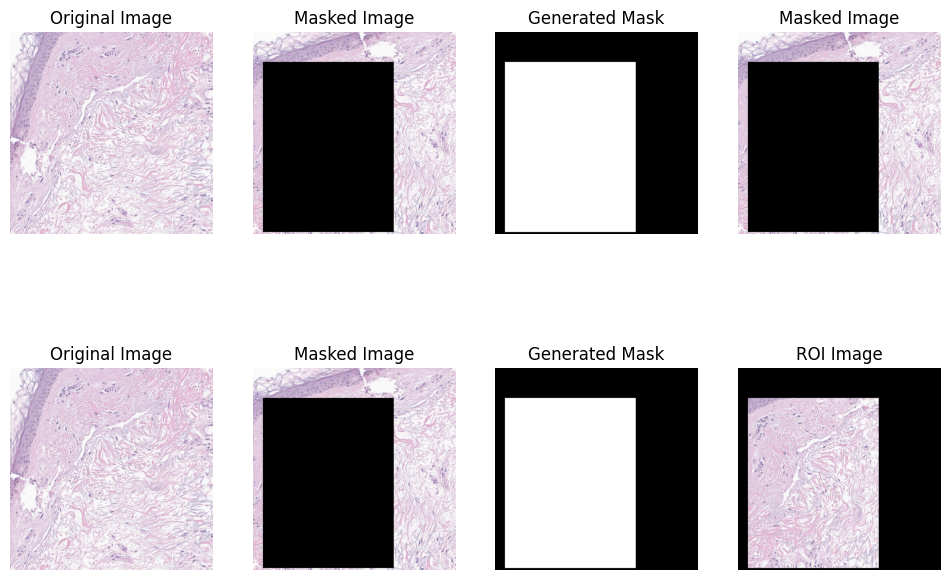

In [46]:
if True:
    # load_image=Image.open("/mayo_atlas/home/m288756/stable-diffusion/data/oneImage/TCGA-22-A5C4-01Z-00-DX1.54058689-5CA5-4F92-B18A-86208C24C87D_18432_47104.jpg") #.resize((512,512))
    load_image=Image.open("/home/m288756/stable-diffusion/data/skin/NormalSkin_ARZ_115_HE_21510_8604.jpg")
    image_resized = load_image.copy().resize((512,512))
    
    tumer_patch=Image.open("/home/m288756/stable-diffusion/data/skin/Poor_Diff_93_ARZ_HE_18432_18432.jpg")
    tumer_patch = tumer_patch.copy().resize((512,512))

    image,mask,x1, y1, x2, y2=random_rectangle_mask(image_resized)
    # _, mask,x1, y1, x2, y2=random_rectangle_mask(image_resized)
    
    batch = process_data_roi(image,mask,tumer_patch,x1, y1, x2, y2,size=512)
    # batch = process_data_roi(load_image,mask,tumer_patch,x1, y1, x2, y2,size=512)

    image_tensor=batch["image_tensor"]
    mask_tensor=batch["mask_tensor"]
    masked_image_tensor=batch["masked_image_tensor"]
    roi=batch["roi"]


    # Save images in two rows using plt
    plt.figure(figsize=(12, 8))

    # First row: Original Image, Generated Mask, Masked Image
    plt.subplot(2, 4, 1)
    plt.imshow(((image_tensor + 1.0) / 2.0).squeeze().numpy().transpose(2,1,0))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 4, 2)
    plt.imshow(((masked_image_tensor + 1.0) / 2.0).squeeze().numpy().transpose(1,2,0))
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(2, 4, 3)
    plt.imshow(((mask_tensor + 1.0) / 2.0).squeeze().numpy(), cmap='gray')
    plt.title('Generated Mask')
    plt.axis('off')

    plt.subplot(2, 4, 4)
    plt.imshow(((masked_image_tensor + 1.0) / 2.0).squeeze().numpy().transpose(1,2,0))
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(2, 4, 5)
    plt.imshow(((image_tensor + 1.0) / 2.0).squeeze().numpy().transpose(2,1,0))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 4, 6)
    plt.imshow(((masked_image_tensor + 1.0) / 2.0).squeeze().numpy().transpose(1,2,0))
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(2, 4, 7)
    plt.imshow(((mask_tensor + 1.0) / 2.0).squeeze().numpy(), cmap='gray')
    plt.title('Generated Mask')
    plt.axis('off')

    plt.subplot(2, 4, 8)
    plt.imshow(((roi + 1.0) / 2.0).squeeze().numpy().transpose(1,2,0))
    plt.title('ROI Image')
    plt.axis('off')

    plt.show()

    plt.savefig(f"sample_images_rows.png")
    plt.close()

In [44]:
model,sampler=create_model(device)
model.load_state_dict(torch.load('/mayo_atlas/home/m288756/stable-diffusion/models/ldm/inpainting_big/new_model.ckpt')['state_dict'])
# model.load_state_dict(torch.load('/home/m288756/stable-diffusion/someCheckpoints/last1million1epoch.ckpt')['state_dict'])
# model.load_state_dict(torch.load('/mayo_atlas/home/m288756/stable-diffusion/models/ldm/inpainting_big/new_model.ckpt')['state_dict'])
# model.load_state_dict(torch.load('/home/m288756/stable-diffusion/logs1millionMaskedBackgroundNoCrops/2024-01-03T11-16-27_config/checkpoints/trainstep_checkpoints/epoch=000000-step=000011999.ckpt')['state_dict'])
# model.load_state_dict(torch.load("/mayo_atlas/home/m288756/stable-diffusion/logs1millionMaskedBackgroundNoCrops/2024-01-03T11-16-27_config/checkpoints/trainstep_checkpoints/epoch=000002-step=000057999.ckpt")['state_dict'])
model.load_state_dict(torch.load('/mayo_atlas/home/m288756/stable-diffusion/logs1millionMaskedBackgroundNoCrops/2024-01-03T11-16-27_config/checkpoints/last.ckpt')['state_dict'])

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 387.25 M params.
Keeping EMAs of 418.
making attention of type 'none' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'none' with 512 in_channels
Using first stage also as cond stage.
Restored from /home/m288756/stable-diffusion/logs1millionMaskedEdges/2024-01-04T16-44-44_config/checkpoints/last.ckpt with 0 missing and 0 unexpected keys


<All keys matched successfully>

In [47]:
# load_image=Image.open("/mayo_atlas/home/m288756/stable-diffusion/data/oneImage/TCGA-22-A5C4-01Z-00-DX1.54058689-5CA5-4F92-B18A-86208C24C87D_18432_47104.jpg") #.resize((512,512))
# load_image=Image.open("/home/m288756/stable-diffusion/data/skin/NormalSkin_ARZ_115_HE_21510_8604.jpg")
load_image=Image.open("/home/m288756/stable-diffusion/data/skin/NormalSkin_ARZ_115_HE_47322_28680.jpg")
load_image = load_image.copy().resize((512,512))
# image,mask,masked_image,region,masked_BK=random_rectangle_mask(image_resized)
# image,mask, _=random_rectangle_mask(load_image)
# image,_, mask,=random_rectangle_mask(load_image)
image,mask,x1, y1, x2, y2=random_rectangle_mask(load_image)

293


c.shape torch.Size([1, 4, 128, 128])
Data shape for DDIM sampling is (1, 3, 128, 128), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:01<00:00, 25.20it/s]


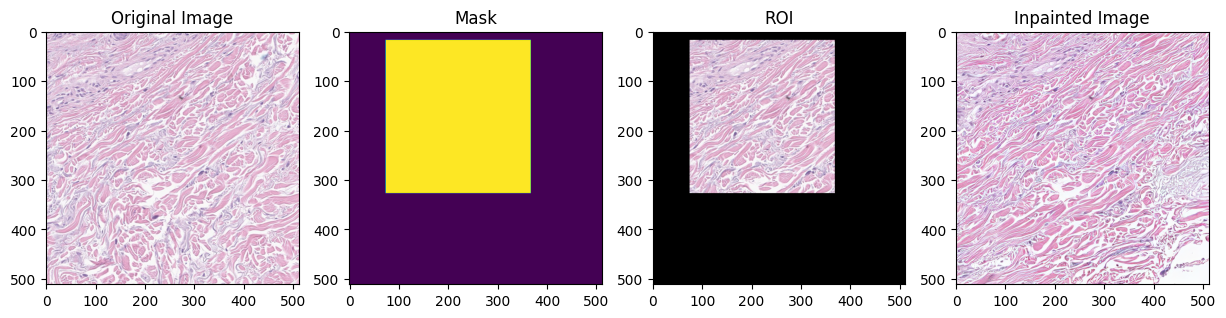

In [48]:
##Inference

target = 'ROI'
# target = 'Masked Image'

# tumer_patch=Image.open("/home/m288756/stable-diffusion/data/skin/Poor_Diff_93_ARZ_HE_18432_18432.jpg") #.resize((512,512))
tumer_patch=Image.open("/home/m288756/stable-diffusion/data/skin/Poor_Diff_93_ARZ_HE_10240_28672.jpg") #.resize((512,512))
tumer_patch = tumer_patch.copy().resize((512,512))

# convert PIL image into input Torch Tensor
# batch=process_data(image,mask,size=512)
# batch = process_data_roi(image,mask,tumer_patch,x1, y1, x2, y2,size=512)
batch = process_data_roi(image,mask,image,x1, y1, x2, y2,size=512)

mask_tensor=batch["mask_tensor"]

if target == 'ROI':
    masked_image_tensor=batch["roi"]
else:
    masked_image_tensor=batch["masked_image_tensor"]


# print(f'image_tensor {image_tensor.shape}'
#       f'mask_tensor {mask_tensor.shape}'
#       f'masked_image_tensor {masked_image_tensor.shape}')

# encode masked image and concat downsampled mask
c = model.cond_stage_model.encode(masked_image_tensor.to(device))

# the mask is frst being downsampled
cc = torch.nn.functional.interpolate(mask_tensor.to(device),
                                    size=c.shape[-2:])
# concat the masked image and downsampled mask
c = torch.cat((c, cc), dim=1)
shape = (c.shape[1]-1,)+c.shape[2:]

print(f'c.shape {c.shape}')

# diffusion process
samples_ddim, _ = sampler.sample(S=50,
                             conditioning=c,
                             batch_size=c.shape[0],
                             shape=shape,
                             verbose=False)


# decode the latent vector (output)
x_samples_ddim = model.decode_first_stage(samples_ddim)


# denormalize the output
predicted_image_clamped = torch.clamp((x_samples_ddim+1.0)/2.0,
                            min=0.0, max=1.0)


output_PIL=transform_PIL(predicted_image_clamped[0])


fig, axes = plt.subplots(1, 4, figsize=(15, 6))  # Create a 1x3 grid for displaying 3 images

# Display each image on a separate subplot
axes[0].imshow(image)
axes[0].set_title('Original Image')

axes[1].imshow(mask)
axes[1].set_title('Mask')

# print(masked_image_tensor.squeeze().numpy().transpose(1,2,0))
axes[2].imshow(((masked_image_tensor + 1.0) / 2.0).squeeze().numpy().transpose(1,2,0))
axes[2].set_title(target)


axes[3].imshow(output_PIL)
axes[3].set_title('Inpainted Image')

plt.show()

In [ ]:
output_PIL=transform_PIL(predicted_image_clamped[0])

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Create a 1x3 grid for displaying 3 images

# Display each image on a separate subplot
axes[0].imshow(image)
axes[0].set_title('original image')

axes[1].imshow(mask)
axes[1].set_title('masked image')

axes[2].imshow(output_PIL)
axes[2].set_title('Inpainted Image')

plt.show()